In [38]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from torchsummary import summary
import matplotlib.pyplot as plt

In [39]:
device = torch.device("cuda")

In [40]:
class NN(nn.Module):

    def __init__(self, input_size: int, num_classes: int):  # input size = 28x28 = 784 for mnist
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [41]:
NUM_PIXELS = 784 # 28x28
BATCH_SIZE = 32
NUM_CLASSES = 10 # 10 numbers: 0-9
EPOCHS = 5

In [42]:
transform = transforms.Compose([ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [43]:
# Hyperparameters
input_size = NUM_PIXELS # 28x28 pixels
learning_rate = 1e-3

# Initialize Network
model = NN(input_size=input_size, num_classes=NUM_CLASSES).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
# Train Network
for epoch in range(EPOCHS):  
# 1 epoch => Network has seen all the images in the dataset
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # print(data.shape)  # => [64 , 1, 28, 28] => 64 : num_images, 1 -> num_channels, (28,28): (height, width)
        data = data.reshape(data.shape[0], -1)  # Flatten
        if epoch == 0 and batch_idx == 0:
            print(data.shape)

        # forward
        scores = model(data)

        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

    print(f"Epoch: {epoch + 1}; Loss: {loss.item()}")

torch.Size([32, 784])
Epoch: 1; Loss: 0.2730785310268402
Epoch: 2; Loss: 0.3083855211734772
Epoch: 3; Loss: 0.16895844042301178
Epoch: 4; Loss: 0.17078272998332977
Epoch: 5; Loss: 0.03409702330827713


In [45]:
image, label = train_set[1]

image.shape

torch.Size([1, 28, 28])

In [46]:
nn_image = image.reshape(-1, NUM_PIXELS)
nn_image.shape

torch.Size([1, 784])

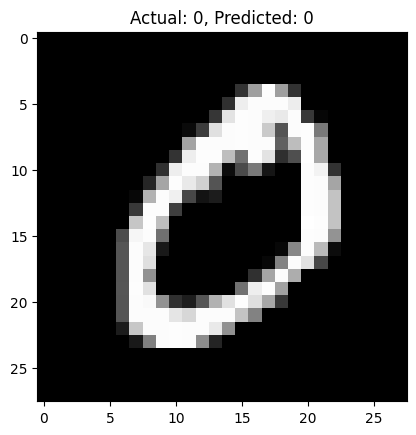

In [47]:
model.eval()
with torch.no_grad():  # dont compute gradients
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}, Predicted: {torch.argmax(model(nn_image.to(device))).item()}")
    plt.show()

In [48]:
summary(model=model, input_size=(NUM_PIXELS,), batch_size=BATCH_SIZE, device="cpu", verbose=0)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            39,250
├─Linear: 1-2                            510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0

## CNN - Convolutional Neural Network
Type of neural network specifically designed for processing data with grid-like topology.

### Basic Architecture
A CNN consists of several key layers that work together to process images:

- Convolutional Layers
    - Process small regions of the input image
    - Use filters (kernels) to detect features
    - Stack multiple layers to capture complex patterns
- Pooling Layers
    - Reduce spatial dimensions of feature maps
    - Help with feature extraction and computation efficiency
    - Common types: Max Pooling and Average Pooling
- Fully Connected Layers
    - Process flattened features for classification
    - Convert 2D/3D data into 1D for final predictions

![CNN](img/convolution.gif)

In [49]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)

        # Average pooling layers
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 2))
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 128)  # 64*7*7 features after flattening
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.avg_pool(x)

        # Dropout
        # x = F.dropout(x, p=0.5, training=self.training)
        
        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.avg_pool(x)

        # Third convolutional block
        # x = F.relu(self.conv3(x))
        # x = self.avg_pool(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [50]:
# Hyperparameters
learning_rate = 1e-3

# Initialize Network
model = CNN(num_classes=NUM_CLASSES).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
# Train Network
for epoch in range(EPOCHS):  
# 1 epoch => Network has seen all the images in the dataset
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # print(data.shape)  # => [64 , 1, 28, 28] => 64 : num_images, 1 -> num_channels, (28,28): (height, width)
        if epoch == 0 and batch_idx == 0:
            print(data.shape)

        # forward
        scores = model(data)

        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

    print(f"Epoch: {epoch + 1}; Loss: {loss.item()}")

torch.Size([32, 1, 28, 28])
Epoch: 1; Loss: 0.00495145982131362
Epoch: 2; Loss: 0.0023327255621552467
Epoch: 3; Loss: 0.005998751614242792
Epoch: 4; Loss: 0.009652737528085709
Epoch: 5; Loss: 0.07264061272144318


In [52]:
cnn_image = image.unsqueeze(0)
cnn_image.shape

torch.Size([1, 1, 28, 28])

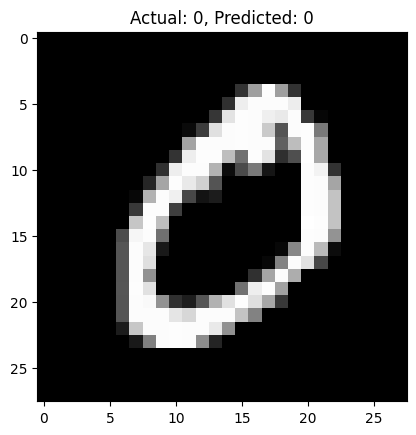

In [53]:
model.eval()
with torch.no_grad():  # dont compute gradients
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}, Predicted: {torch.argmax(model(cnn_image.to(device)), dim=1).item()}")
    plt.show()

In [54]:
summary(model, input_size=(1, 28, 28), batch_size=BATCH_SIZE, device="cpu", verbose=0)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─AvgPool2d: 1-3                         --
├─Linear: 1-4                            401,536
├─Linear: 1-5                            1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0